## 6.3 Batch Normalization

- 前節では「重みの初期値を適切に設定すれば，各層のアクティベーションの分布は適度な広がりを持ち，学習がスムーズに行える」ということを学んだ
- この節ではそのアクティベーション分布を強制的に調整してみる手法 Batch Normalization を紹介する

### 6.3.1 Batch Normalization のアルゴリズム

- 2015 年に提案された手法
- 派生手法もたくさんあるようです
- コンペなどで優れた結果を残している例でよく見かける（というよりほぼ必ず？）

#### Batch Normalization の利点
- 学習を速く進行させることができる（学習係数を大きくすることができる）
- 初期値にそれほど依存しない（初期値に対してそこまで神経質にならなくてよい）
    - この前あった「フレームワークによって同じネットワーク・初期値でもうまく収束したりしなかったりする」問題がなくなる？
- 過学習を抑制する（Dropout などの必要性を減らす）
    - 逆に今 Dropout って使われているんですかね？あまり見かけない気がします．

#### Batch Normalization のアイデア
- 各層でのアクティベーション分布を，適度な広がりを持つように調整すること

#### Batch Normalization の使い方
- データ分布の正規化を行うレイヤをニューラルネットワークに挿入して使う（図6-16）

#### 定義式

ミニバッチ
$$
B = {x_1, x_2, ..., x_m}
$$
に対して

$$
\mu_B = \frac{1}{m} \sum_{i=1}^{m}{x_i}
$$

$$
\sigma_B^2 = \frac{1}{m} \sum_{i=1}^{m}{\left( x_i - \mu_B \right)^2}
$$

$$
\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
$$

式で行っていることは，
- ミニバッチの入力データ ${x1, x2, .., x_m}$ を，平均0，分散1のデータ ${\hat{x}_1, \hat{x}_2, ..., \hat{x}_m}$ に変換する

こと．

ここからさらに 正規化された ${\hat{x}_i}$ に対して，固有のスケール $\gamma$ とシフト $\beta$ で変換を行う．

$$
y_i = \gamma \hat{x}_i + \beta
$$

$\gamma$, $\beta$ はパラメータ，$\gamma = 1, \beta = 0$ を初期値としてこれまでの全結合層と同様に学習を行う．（$\gamma$, $\beta$ はスカラでない場合もある）

微分の導出が意外と大変なんですね...

#### 数値例

##### BatchNormalization なし

In [1]:
from collections import OrderedDict

import numpy as np
np.random.seed(7)
import matplotlib.pyplot as plt
import tqdm
from sklearn import datasets
from sklearn.model_selection import train_test_split

from network import trainer
from network import visualizer
from network import layers as L
from network import functions as F
from network.module import SequenceNet

In [2]:
# loading training data
load = datasets.load_digits
X, y = load(return_X_y=True)
# from sklearn.datasets import fetch_openml
# X, y = fetch_openml('mnist_784', return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y.astype("int"), test_size=0.3)

feature_size = X_train.shape[1]
num_classes = int(np.max(y)) + 1
Y_train = np.eye(num_classes)[y_train]
Y_test = np.eye(num_classes)[y_test]

In [3]:
# training parameters
num_epoch = 100
batch_size = 8
lr = 0.01
l1 = 0.000
l2 = 0.000

In [4]:
# network definition
neuron_size = 200
sequence = [
    L.Linear(n_in=feature_size, n_out=neuron_size),
    L.ReLU(),
    L.Linear(n_in=neuron_size, n_out=num_classes),
]
net = SequenceNet(layers=sequence, loss=L.SoftmaxCrossEntropy(), l1=l1, l2=l2)

In [5]:
# train network
loss_train, acc_train, loss_test, acc_test, histories = trainer.train(
    net=net, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test,
    num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr
)

print(f"sum_weights_abs: {net.sum_weights_abs:.3f}")
print(f"sum_weights_pow2: {net.sum_weights_pow2:.3f}")

epoch    99: 100%|██████████| 100/100 [00:16<00:00,  6.20it/s, loss_train=-9.96e-8, acc_train=1, loss_test=0.599, acc_test=0.959]  

sum_weights_abs: 11766.328
sum_weights_pow2: 14675.081


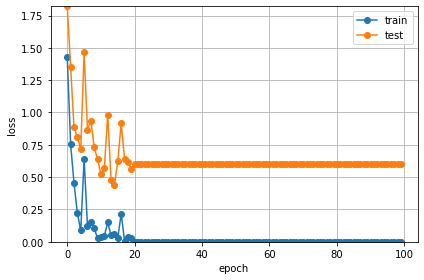

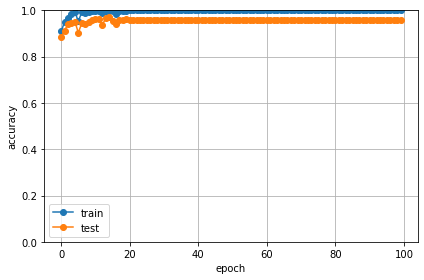

In [6]:
# visualize
visualizer.visualize_histories(histories)

##### BatchNormalization あり

In [7]:
# training parameters
num_epoch = 100
batch_size = 8
lr = 0.01
l1 = 0.000
l2 = 0.000

In [8]:
# network definition
neuron_size = 200
sequence = [
    L.BatchNormalization(n_out=feature_size),
    L.Linear(n_in=feature_size, n_out=neuron_size),
    L.ReLU(),
    L.BatchNormalization(n_out=neuron_size),
    L.Linear(n_in=neuron_size, n_out=num_classes),
]
net = SequenceNet(layers=sequence, loss=L.SoftmaxCrossEntropy(), l1=l1, l2=l2)

In [9]:
# train network
loss_train, acc_train, loss_test, acc_test, histories = trainer.train(
    net=net, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test,
    num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr
)

print(f"sum_weights_abs: {net.sum_weights_abs:.3f}")
print(f"sum_weights_pow2: {net.sum_weights_pow2:.3f}")

epoch    99: 100%|██████████| 100/100 [00:23<00:00,  4.28it/s, loss_train=0.0882, acc_train=0.983, loss_test=0.213, acc_test=0.961]

sum_weights_abs: 11760.673
sum_weights_pow2: 14672.023


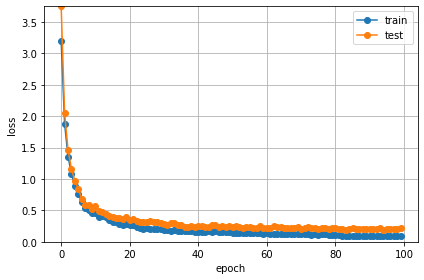

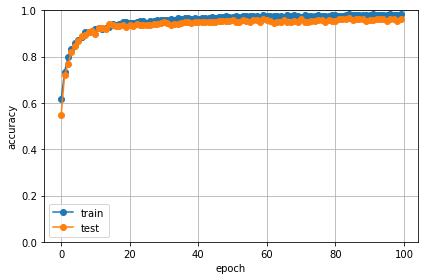

In [10]:
# visualize
visualizer.visualize_histories(histories)

## 6.4 正則化

- 機械学習の問題では，過学習がよく問題になる
- 過学習とは，訓練データだけに適応しすぎてしまい，訓練データに含まれない他のデータにはうまく対応できない状態
- 未知のデータに対しても正しく識別できるモデルが理想
- NN は複雑で表現力が高いモデルにすることが簡単だが，その分過学習を抑制するテクニックが重要になる

### 6.4.1 過学習

過学習が起きる主な原因
- パラメータを大量に持ち，表現力の高いモデルであること
- 訓練データが少ないこと

今から実際に起こしてみましょう．

### 6.4.2 Weight decay

- 昔からよく用いられているそうです
- Weight decay: L2 ノルムを正則化項として損失関数に加算する正則化のこと
- L1 ノルム正則化もある
- これらを一般化した Lp ノルム正則化もある

ノルム正則化の効果
- L1 ノルム正則化はパラメータのスパース化
- L2 ノルム正則化はパラメータのレンジを狭くする

実際の正則化項をあわせた式は L1 正則化も含めると以下のようになる．

$$
L_{12}\left(W_i\right) = L\left(W_i\right) + \lambda_1 \sum_{i} \left|W_{i}\right| + \frac{1}{2} \lambda_2 \sum_{i} W^2_{i}
$$

学習の際には正則化したい重みでの微分に加えて，正則化項の微分も加算する．

#### 数値例

##### 正則化あり

In [11]:
# training parameters
num_epoch = 100
batch_size = 8
lr = 0.01
l1 = 0.01
l2 = 0.01

In [12]:
# network definition
neuron_size = 200
sequence = [
    L.Linear(n_in=feature_size, n_out=neuron_size),
    L.ReLU(),
    L.Linear(n_in=neuron_size, n_out=num_classes),
]
net = SequenceNet(layers=sequence, loss=L.SoftmaxCrossEntropy(), l1=l1, l2=l2)

In [13]:
# train network
loss_train, acc_train, loss_test, acc_test, histories = trainer.train(
    net=net, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test,
    num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr
)

print(f"sum_weights_abs: {net.sum_weights_abs:.3f}")
print(f"sum_weights_pow2: {net.sum_weights_pow2:.3f}")

epoch    99: 100%|██████████| 100/100 [00:16<00:00,  6.08it/s, loss_train=0.55, acc_train=0.955, loss_test=0.606, acc_test=0.943]

sum_weights_abs: 35.466
sum_weights_pow2: 8.751


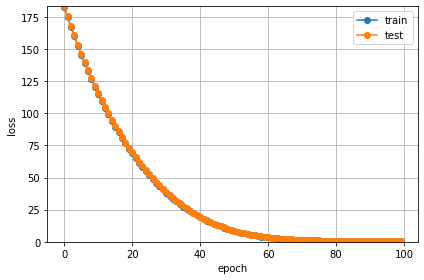

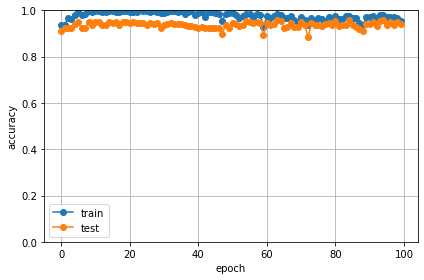

In [14]:
# visualize
visualizer.visualize_histories(histories)

- 収束が遅れた代わりに，十分に正則化がかかると，訓練データでの指標がテストデータでの指標に近づいている．

### 6.4.3 Dropout

- モデルが複雑になってくると Weight Decay だけでは対応が困難になる
- そこで Dropout を用いた過学習抑制を行う

何をやっているのか
- ニューロンをランダムに消去しながら学習する手法
- 一定の確率（これは自分で設定する）で Dropout 層に入ってきた値を伝搬させない処理を行う

Dropout の効果
- 毎回異なるニューロンで推論を行うため，NN の中に冗長性が生まれ，アンサンブル学習と同じような効果が期待できる

実際にその効果を動かしながら見てみましょう．

In [15]:
# training parameters
num_epoch = 100
batch_size = 8
drop_ratio = 0.75
lr = 0.01
l1 = 0.000
l2 = 0.000

In [16]:
# network definition
neuron_size = 200
sequence = [
    L.Dropout(drop_ratio=drop_ratio),
    L.Linear(n_in=feature_size, n_out=neuron_size),
    L.ReLU(),
    L.Dropout(drop_ratio=drop_ratio),
    L.Linear(n_in=neuron_size, n_out=num_classes),
]
net = SequenceNet(layers=sequence, loss=L.SoftmaxCrossEntropy(), l1=l1, l2=l2)

In [17]:
# train network
loss_train, acc_train, loss_test, acc_test, histories = trainer.train(
    net=net, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test,
    num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr
)

print(f"sum_weights_abs: {net.sum_weights_abs:.3f}")
print(f"sum_weights_pow2: {net.sum_weights_pow2:.3f}")

epoch    99: 100%|██████████| 100/100 [00:17<00:00,  5.68it/s, loss_train=0.0286, acc_train=0.993, loss_test=0.431, acc_test=0.944]

sum_weights_abs: 11822.551
sum_weights_pow2: 14873.231


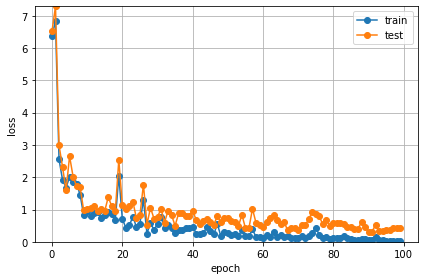

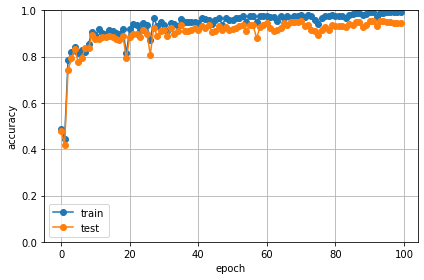

In [18]:
# visualize
visualizer.visualize_histories(histories)

## 6.5 ハイパーパラメータの検証

NN におけるハイパーパラメータとは
- 層の数
- 各層のニューロンの数
- バッチサイズ
- 学習率
- 正則化係数
- etc.

これらを適切な値に設定しなければ，学習はうまく進まない．
しかし探索するのも一苦労．

代表的な方法
- random search
- grid search
- ランダムに gird search を行う方法
- ベイズ最適化を用いた方法

### random search を使った例

In [19]:
np.random.seed(7)

In [20]:
class ObjectiveRandomSearch(object):
    def __init__(self, X_train, Y_train, X_val, Y_val, num_epoch):
        # Hold this implementation specific arguments as the fields of the class.
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_val = X_val
        self.Y_val = Y_val
        self.num_epoch = num_epoch
        self.params = None
        self.best_params = None
        self.best_value = np.inf

    def __call__(self):
        # Calculate an objective value
        num_epoch = self.num_epoch
        batch_size = [8, 16, 32][np.random.randint(low=0, high=3)]
        lr = np.random.rand() * (0.1 - 0.001) + 0.001
        l1 = np.random.rand() * 0.0
        l2 = np.random.rand() * 0.0
        num_fc_unit = [0, 1, 2, 4][np.random.randint(low=0, high=4)]
        neuron_size = [50, 100, 200][np.random.randint(low=0, high=3)]
        params = {
            "num_epoch": num_epoch, "batch_size": batch_size,
            "learning_rate": lr,
            "l1": l1, "l2": l2, "num_fc_unit": num_fc_unit,
            "neuron_size": neuron_size,
        }

        # network definition
        head = [
            L.BatchNormalization(n_out=feature_size),
            L.Linear(n_in=feature_size, n_out=neuron_size),
            L.ReLU(),
        ]
        fc_unit = [
            L.BatchNormalization(n_out=neuron_size),
            L.Linear(n_in=neuron_size, n_out=neuron_size),
            L.ReLU(),
        ]
        classifier = [
            L.BatchNormalization(n_out=neuron_size),
            L.Linear(n_in=neuron_size, n_out=num_classes),
        ]
        layers = head + num_fc_unit * fc_unit + classifier
        net = SequenceNet(layers=layers, loss=L.SoftmaxCrossEntropy(), l1=l1, l2=l2)

        # train network
        loss_train, acc_train, loss_val, acc_val, histories = trainer.train(
            net=net, X_train=self.X_train, Y_train=self.Y_train, X_test=self.X_val, Y_test=self.Y_val,
            num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr
        )

        loss_val = np.inf if np.isnan(loss_val) else loss_val
        self.update_best_params(loss_val=loss_val, params=params)

        return loss_val

    def update_best_params(self, loss_val, params):
        if loss_val < self.best_value:
            self.best_value = loss_val
            self.best_params = params

In [21]:
obj_rs = ObjectiveRandomSearch(X_train, Y_train, X_test, Y_test, num_epoch=20)

In [22]:
loss_val = np.inf
for trial in range(50):
    obj_rs()

epoch     2:  15%|█▌        | 3/20 [00:00<00:02,  5.70it/s, loss_train=1.38, acc_train=0.58, loss_test=1.42, acc_test=0.548]/home/wattai/miniconda3/envs/zerokara/lib/python3.8/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/wattai/miniconda3/envs/zerokara/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/mnt/c/Users/evama/zerokara/6_3-6_5/network/layers.py:60: RuntimeWarning: overflow encountered in multiply
  return coefficient * grad_block
/mnt/c/Users/evama/zerokara/6_3-6_5/network/module.py:30: RuntimeWarning: overflow encountered in square
  self.sum_weights_pow2 += np.sum(layer.params["w"] ** 2.0)
/mnt/c/Users/evama/zerokara/6_3-6_5/network/layers.py:15: RuntimeWarning: overflow encountered in matmul
  return self.x @ self.params["w"] + self.params["b"]
/home/wattai/miniconda3/envs/zerokara/lib/python3

In [23]:
obj_rs.best_value

0.15120275860013363

In [24]:
obj_rs.best_params

{'num_epoch': 20,
 'batch_size': 8,
 'learning_rate': 0.07821196043177135,
 'l1': 0.0,
 'l2': 0.0,
 'num_fc_unit': 0,
 'neuron_size': 100}

### optuna を使った例

In [25]:
import optuna

In [26]:
np.random.seed(7)

In [27]:
class ObjectiveOptuna(object):
    def __init__(self, X_train, Y_train, X_val, Y_val, num_epoch):
        # Hold this implementation specific arguments as the fields of the class.
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_val = X_val
        self.Y_val = Y_val
        self.num_epoch = num_epoch

    def __call__(self, trial):
        # Calculate an objective value by using the extra arguments.
        num_epoch = trial.suggest_categorical("num_epoch", [self.num_epoch])
        batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
        lr = trial.suggest_float("learning_rate", 0.001, 0.1)
        l1 = trial.suggest_float("lambda_1", 0.0, 0.0)
        l2 = trial.suggest_float("lambda_2", 0.0, 0.0)
        num_fc_unit = trial.suggest_categorical("num_fc_unit", [0, 1, 2, 4])
        neuron_size = trial.suggest_categorical("neuron_size", [50, 100, 200])
        
        # network definition
        head = [
            L.BatchNormalization(n_out=feature_size),
            L.Linear(n_in=feature_size, n_out=neuron_size),
            L.ReLU(),
        ]
        fc_unit = [
            L.BatchNormalization(n_out=neuron_size),
            L.Linear(n_in=neuron_size, n_out=neuron_size),
            L.ReLU(),
        ]
        classifier = [
            L.BatchNormalization(n_out=neuron_size),
            L.Linear(n_in=neuron_size, n_out=num_classes),
        ]
        layers = head + num_fc_unit * fc_unit + classifier
        net = SequenceNet(layers=layers, loss=L.SoftmaxCrossEntropy(), l1=l1, l2=l2)

        # train network
        loss_train, acc_train, loss_val, acc_val, histories = trainer.train(
            net=net, X_train=self.X_train, Y_train=self.Y_train, X_test=self.X_val, Y_test=self.Y_val,
            num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr
        )
        loss_val = np.inf if np.isnan(loss_val) else loss_val
        return loss_val

In [28]:
obj_optuna = ObjectiveOptuna(X_train, Y_train, X_test, Y_test, num_epoch=20)

In [29]:
# Execute an optimization by using an `Objective` instance.
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=7))
study.optimize(obj_optuna, n_trials=50)

[I 2020-10-20 01:53:48,790] A new study created in memory with name: no-name-4048aedb-6b41-4cee-90b0-b865953cffb6
  0%|          | 0/20 [00:00<?, ?it/s]/home/wattai/miniconda3/envs/zerokara/lib/python3.8/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/mnt/c/Users/evama/zerokara/6_3-6_5/network/layers.py:19: RuntimeWarning: overflow encountered in matmul
  self.x.T @ dy + l1 * np.sign(self.params["w"]) + l2 * self.params["w"]
/mnt/c/Users/evama/zerokara/6_3-6_5/network/layers.py:19: RuntimeWarning: invalid value encountered in matmul
  self.x.T @ dy + l1 * np.sign(self.params["w"]) + l2 * self.params["w"]
/mnt/c/Users/evama/zerokara/6_3-6_5/network/layers.py:22: RuntimeWarning: overflow encountered in matmul
  return dy @ self.params["w"].T
/mnt/c/Users/evama/zerokara/6_3-6_5/network/layers.py:22: RuntimeWarning: invalid value encountered in matmul
  return dy @ self.params["w"].T
/mnt/c/Users/evama/zerokara/6_3-

### ベストパラメータ

In [30]:
study.best_params

{'num_epoch': 20,
 'batch_size': 8,
 'learning_rate': 0.08097571047031088,
 'lambda_1': 0.0,
 'lambda_2': 0.0,
 'num_fc_unit': 0,
 'neuron_size': 50}

In [31]:
study.best_value

0.11868321277002541